In [1]:
pip install -U statsmodels

In [2]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
import pandas as pd
import numpy as np

In [3]:
!wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

--2024-12-19 01:59:52--  https://lazyprogrammer.me/course_files/airline_passengers.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2036 (2.0K) [text/csv]
Saving to: ‘airline_passengers.csv’

airline_passengers. 100%[===================>]   1.99K  --.-KB/s    in 0s      

2024-12-19 01:59:52 (36.6 MB/s) - ‘airline_passengers.csv’ saved [2036/2036]



In [4]:
df = pd.read_csv("airline_passengers.csv",index_col = "Month",parse_dates = True)

In [5]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [6]:
alpha = 0.2

In [7]:
df["EWMA"] = df["Passengers"].ewm(alpha = alpha,adjust=False).mean()

In [8]:
ses = SimpleExpSmoothing(df["Passengers"])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [9]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [10]:
df.index.freq = "MS"

In [11]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq='MS')

In [12]:
ses = SimpleExpSmoothing(df["Passengers"],
                         initialization_method = "legacy-heuristic")

In [13]:
res = ses.fit(smoothing_level= alpha,optimized = False)

In [14]:
res

In [15]:
res.predict(start = df.index[0],end = df.index[-1])

,0
Month,
1949-01-01,112.000000
1949-02-01,112.000000
1949-03-01,113.200000
1949-04-01,116.960000
1949-05-01,119.368000
...,...
1960-08-01,488.767616
1960-09-01,512.214093
1960-10-01,511.371274


In [16]:
df["SES"] = res.predict(start = df.index[0],end = df.index[-1])

In [17]:
## The expression np.allclose(df["SES"], res.fittedvalues) is used to compare two arrays element-wise and checks whether they are approximately equal within a specified tolerance
np.allclose(df["SES"],res.fittedvalues)

True

<Axes: xlabel='Month'>

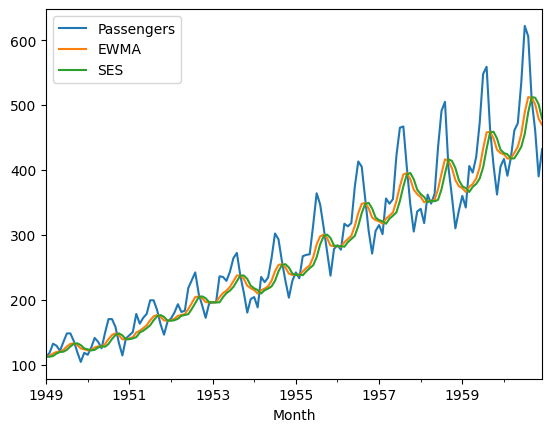

In [18]:
df.plot()

If we observe the above graph we can find that the EWMA from pandas and statsmodels are little shifted

Lets see the below steps to see whats happening

>



In [19]:
df.head()

,Passengers,EWMA,SES
Month,,,
1949-01-01,112,112.0000,112.000
1949-02-01,118,113.2000,112.000
1949-03-01,132,116.9600,113.200
1949-04-01,129,119.3680,116.960
1949-05-01,121,119.6944,119.368


In [20]:
df["SES-1"] = df["SES"].shift(-1)

In [21]:
df.head()

,Passengers,EWMA,SES,SES-1
Month,,,,
1949-01-01,112,112.0000,112.000,112.0000
1949-02-01,118,113.2000,112.000,113.2000
1949-03-01,132,116.9600,113.200,116.9600
1949-04-01,129,119.3680,116.960,119.3680
1949-05-01,121,119.6944,119.368,119.6944


<Axes: xlabel='Month'>

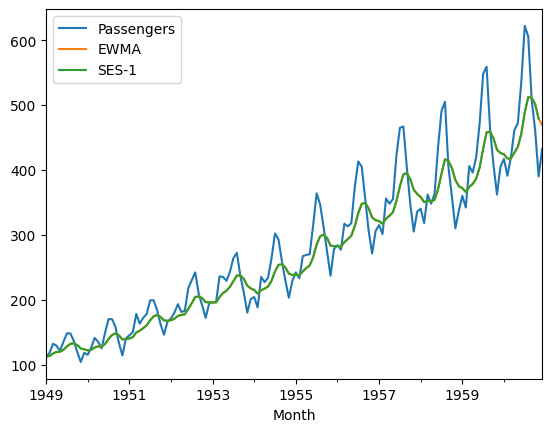

In [22]:
### NO this shifting is not allowed
df[["Passengers","EWMA","SES-1"]].plot()

In [23]:
from statsmodels.tsa.holtwinters import Holt

In [24]:
holt = Holt(
    df["Passengers"], initialization_method = 'legacy-heuristic'
)


In [25]:
res_h = holt.fit()

In [26]:
df["Holt"] = res_h.fittedvalues

In [27]:
df.head()

,Passengers,EWMA,SES,SES-1,Holt
Month,,,,,
1949-01-01,112,112.0000,112.000,112.0000,118.000000
1949-02-01,118,113.2000,112.000,113.2000,118.007089
1949-03-01,132,116.9600,113.200,116.9600,123.977209
1949-04-01,129,119.3680,116.960,119.3680,137.967695
1949-05-01,121,119.6944,119.368,119.6944,135.018254


<Axes: xlabel='Month'>

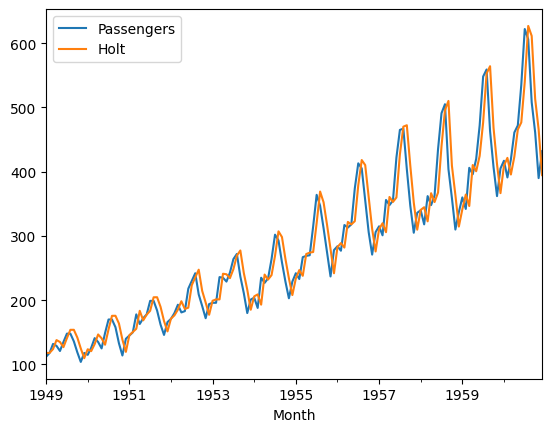

In [28]:
df[["Passengers","Holt"]].plot()

In [29]:
### NO!
